## Importing Libraries

In [4]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns

## Defining Functions

In [6]:
def get_csv_files():
    current_dir = os.getcwd()
    parent_dir = os.path.dirname(current_dir)
    raw_data_dir = os.path.join(parent_dir, "Raw Station Datasets")
    csv_files = glob.glob(os.path.join(raw_data_dir, '*.csv'))
    filtered_files = sorted([file for file in csv_files if os.path.basename(file)[:3].isdigit()],
                            key=lambda x: int(os.path.basename(x)[:3]))
    return filtered_files

def process_csv_file(file):
    try:
        with open(file, 'r') as f:
            meta_lines = [f.readline().strip() for _ in range(12)]

        # Extract headers and units
        headers = meta_lines[10].split(',')  # Line 11
        units = meta_lines[11].split(',')    # Line 12
        new_headers = [f'{header.strip()}({unit.strip()})' if unit.strip() else header.strip()
                       for header, unit in zip(headers, units)]

        # Load the DataFrame
        df = pd.read_csv(file, skiprows=12, names=new_headers, low_memory=False)

        # Check for the presence of 'Date_time' or similar column
        date_column = next((col for col in df.columns if 'date' in col.lower() or 'time' in col.lower()), None)
        if date_column is None:
            raise ValueError("No date/time column found in file.")
        
        df[date_column] = pd.to_datetime(df[date_column], errors='coerce')  # Convert to datetime, coerce errors to NaT
        df = df.rename(columns={date_column: 'Date_time'})  # Rename to 'Date_time' for consistency
        
        return df, meta_lines[4:10]  # Generate metadata return
    except Exception as e:
        print(f"Error processing {os.path.basename(file)}: {e}")
        return None, None

def plot_data_availability(csv_files):
    availability = pd.DataFrame()

    for i, file in enumerate(csv_files):
        df, _ = process_csv_file(file)
        if df is not None and 'Date_time' in df.columns:
            df.set_index('Date_time', inplace=True)
            daily_availability = df.resample('D').size().rename('Count')
            availability[f'Station {i+1}'] = daily_availability > 0

    if availability.empty:
        print("No data available for plotting.")
        return

    availability = availability.fillna(False).astype(int)

    plt.figure(figsize=(15, 8))
    plt.imshow(availability.T, aspect='auto', cmap='Greens', interpolation='nearest')
    plt.colorbar(label='Data Availability (1: Available, 0: Not Available)')
    plt.title('Data Availability Across Stations Over Time')
    plt.xlabel('Date')
    plt.ylabel('Station Number')
    plt.xticks(range(0, len(availability.index), 30), availability.index.date[::30], rotation=45)
    plt.yticks(range(len(availability.columns)), availability.columns)
    plt.tight_layout()
    plt.show()

def plot_variable_presence(csv_files):
    all_variables = []
    
    for file in csv_files:
        df, _ = process_csv_file(file)
        if df is not None:
            for col in df.columns:
                if col not in all_variables:
                    all_variables.append(col)

    availability_matrix = pd.DataFrame(0, index=[f'Station {i+1}' for i in range(len(csv_files))], columns=all_variables)

    for i, file in enumerate(csv_files):
        df, _ = process_csv_file(file)
        if df is not None:
            availability_matrix.loc[f'Station {i+1}', df.columns] = 1

    plt.figure(figsize=(15, 10))
    sns.heatmap(availability_matrix, cmap='Blues', annot=False, cbar=True, linewidths=0.5)
    plt.title('Variable Availability Across Stations')
    plt.xlabel('Variables')
    plt.ylabel('Stations')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

def calculate_total_days(csv_files):
    total_days = []
    for file in csv_files:
        df, _ = process_csv_file(file)
        if df is not None and 'Date_time' in df.columns:
            total_days.append(df['Date_time'].dt.date.nunique())  # Count unique days
        else:
            total_days.append(0)  # If data is not available, count as 0
    return total_days

def plot_total_days(csv_files, total_days):
    station_numbers = [int(os.path.basename(file)[:3]) for file in csv_files]
    
    plt.figure(figsize=(12, 6))
    plt.bar(station_numbers, total_days)
    plt.title('Total Number of Days of Data Available per Station')
    plt.xlabel('Station Number')
    plt.ylabel('Total Days')
    plt.xticks(station_numbers, rotation=45)
    plt.tight_layout()
    plt.show()

## Executing the functions

C:\Users\as0780\AppData\Local\Temp\ipykernel_19248\767792260.py:51: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  availability = availability.fillna(False).astype(int)


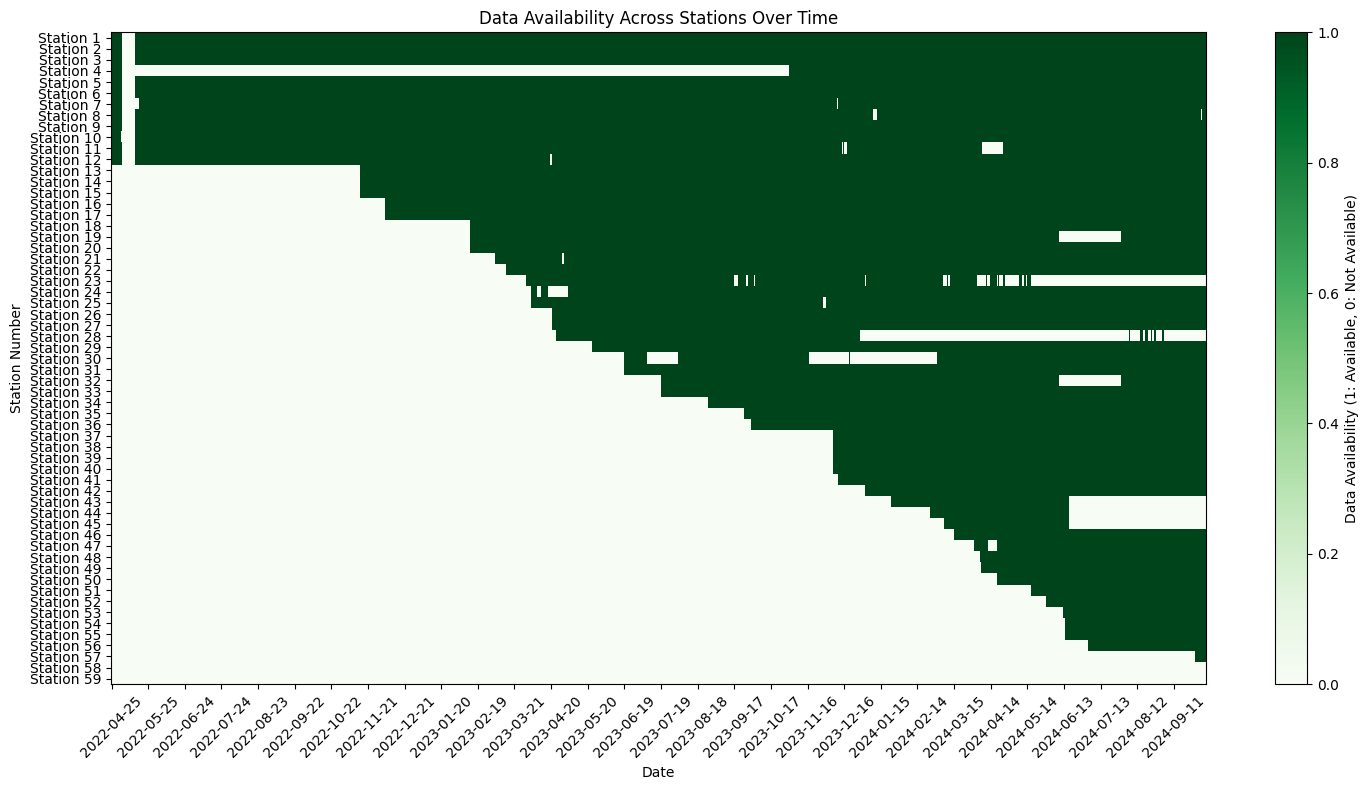

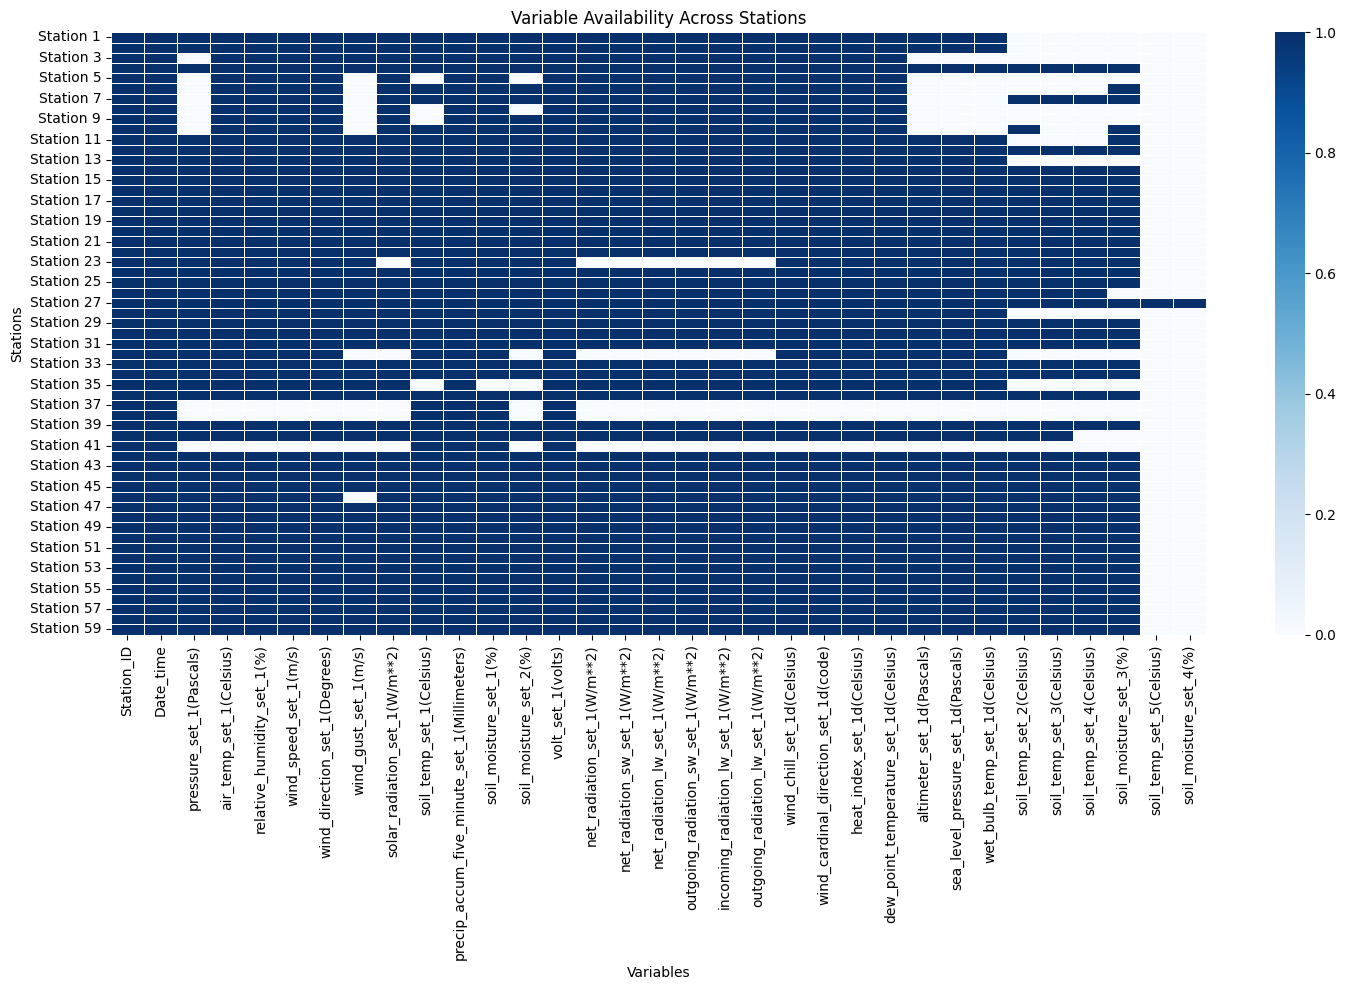

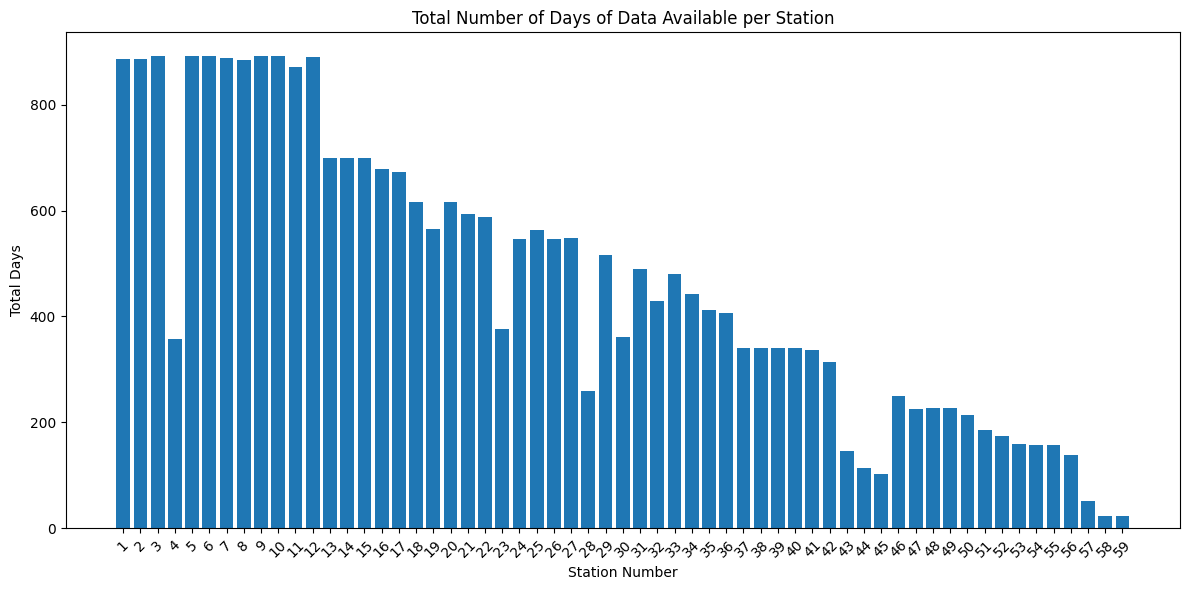

In [7]:
# Execute the code
csv_files = get_csv_files()
plot_data_availability(csv_files)
plot_variable_presence(csv_files)
total_days_per_station = calculate_total_days(csv_files)
plot_total_days(csv_files, total_days_per_station)